<a href="https://colab.research.google.com/github/jpoist97/lab-5-jpoist97/blob/main/DATA_301_Lab_5_Justin_Poist%2C_Shriya_Nimmagadda.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Authorship of the Federalist Papers

The _Federalist Papers_ were a set of 85 essays published between 1787 and 1788 to promote the ratification of the United States Constitution. They were originally published under the pseudonym "Publius". Although the identity of the authors was a closely guarded secret at the time, most of the papers have since been conclusively attributed to one of Hamilton, Jay, or Madison. The known authorships can be found in `https://dlsun.github.io/pods/data/federalist/authorship.csv`.

For 15 of the papers, however, the authorships remain disputed. (These papers can be identified from the `authorship.csv` file because the "Author" field is blank.) In this analysis, you will use the papers with known authorship to predict the authorships of the disputed papers. The text of each paper is available at `https://dlsun.github.io/pods/data/federalist/x.txt`, where `x` is the number of the paper (i.e., a number from 1 to 85). The name of the file indicates the number of the paper.

In [ ]:
import pandas as pd
df_federalist = pd.read_csv("https://dlsun.github.io/pods/data/federalist/authorship.csv")
unknown_papers = df_federalist[pd.isna(df_federalist["Author"])]

## Question 1

When analyzing an author's style, common words like "the" and "on" are actually more useful than rare words like "hostilities". That is because rare words typically signify context. Context is useful if you are trying to find documents about similar topics, but not so useful if you are trying to identify an author's style because different authors can write about the same topic. For example, both Dr. Seuss and Charles Dickens used rare words like "chimney" and "stockings" in _How the Grinch Stole Christmas_ and _A Christmas Carol_, respectively. But they used common words very differently: Dickens used the word "upon" over 100 times, while Dr. Seuss did not use "upon" even once.

Read in the Federalist Papers. Convert each one into a vector of term frequencies. In order to restrict to common words, include only the top 50 words across the corpus. (Because we are restricting to the most common words already, there is no reason to reweight them using TF-IDF.)

In [ ]:
import requests
from sklearn.feature_extraction.text import CountVectorizer


federalist_papers = pd.Series()

for paper_num in range(1, 86):
  response = requests.get("https://dlsun.github.io/pods/data/federalist/" + str(paper_num) + ".txt", "r")
  federalist_papers[str(paper_num)] = response.text

federalist_papers

vec = CountVectorizer(max_features=50)
vec.fit(federalist_papers) # This determines the vocabulary.
tf_sparse = vec.transform(federalist_papers)

df_word_counts = pd.DataFrame(
    tf_sparse.todense(),
    columns=vec.get_feature_names()
)
df_word_counts = df_federalist.join(df_word_counts)
df_word_counts

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  """
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,Paper,Author,all,an,and,any,are,as,at,be,been,but,by,can,constitution,for,from,government,has,have,if,in,is,it,its,may,more,no,not,of,on,one,or,other,people,power,state,states,than,that,the,their,them,they,this,those,to,we,which,will,with,would
0,1,Hamilton,9,11,40,6,12,10,8,34,3,2,14,3,8,12,11,9,6,10,4,27,13,20,10,11,7,3,14,106,9,4,6,3,6,2,6,2,11,28,133,14,2,6,14,9,72,8,18,25,6,2
1,2,Jay,4,1,83,1,6,16,10,15,8,8,10,0,0,13,4,9,6,17,3,34,16,38,5,4,5,1,10,83,8,10,10,4,23,1,1,2,5,44,107,21,4,22,14,2,53,5,11,2,13,5
2,3,Jay,4,3,60,5,8,24,1,31,2,7,18,3,0,11,15,16,5,7,7,25,7,21,1,6,13,2,13,62,6,8,32,7,8,3,8,11,8,20,93,11,8,5,6,6,56,0,11,24,10,2
3,4,Jay,4,3,90,5,11,20,2,26,2,10,14,8,0,12,8,16,1,9,14,24,10,28,9,10,13,1,14,72,11,13,24,11,8,2,6,1,9,17,86,19,12,17,1,4,51,10,10,15,12,17
4,5,Jay,4,4,72,3,3,3,4,31,0,4,10,1,0,7,11,2,0,1,3,28,7,21,4,2,11,2,8,53,5,10,10,4,3,1,2,1,9,23,66,11,11,11,6,9,45,5,10,7,11,37
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
80,81,Hamilton,13,22,88,15,15,46,7,85,22,20,32,6,13,21,20,7,12,23,6,135,61,65,10,25,4,8,26,248,16,10,21,6,1,20,26,18,6,49,389,11,16,11,44,12,163,2,41,30,14,21
81,82,Hamilton,7,10,41,1,11,15,2,36,1,4,4,5,4,4,14,3,0,7,2,38,15,13,4,14,1,4,13,94,0,9,13,2,1,10,18,8,3,19,168,6,4,10,14,6,83,2,18,7,6,11
82,83,Hamilton,28,20,121,16,43,54,19,105,36,25,82,6,13,39,22,16,22,54,24,213,116,102,21,16,23,22,36,331,18,18,26,21,3,10,33,23,16,121,485,16,21,29,60,13,219,5,79,24,30,48
83,84,Hamilton,14,15,89,32,33,35,10,94,18,18,31,11,28,27,20,25,19,27,8,91,68,64,7,26,7,27,30,293,21,5,21,10,11,13,27,19,16,84,390,29,5,22,36,9,140,11,53,38,14,18


## Question 2
Make a visualization that summarizes the most common words used by Hamilton, Madison, and Jay.

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


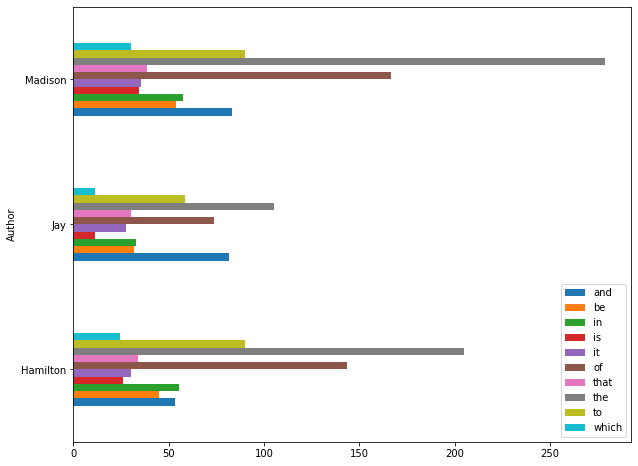

In [ ]:
top_10_vec = CountVectorizer(max_features=10)
top_10_vec.fit(federalist_papers)
top_10_sparse = top_10_vec.transform(federalist_papers)

word_columns = top_10_vec.get_feature_names()

df_top_10 = pd.DataFrame(
    top_10_sparse.todense(),
    columns=word_columns
)
df_top_10 = df_federalist.join(df_top_10)

df_top_10.groupby("Author")[word_columns].mean().plot.barh(figsize=(10,8))

## Question 3

For each of the documents with disputed authorships, find the 5 most similar documents with _known_ authorships, using cosine distance on the term frequencies. Use the authors of these 5 most similar documents to predict the author of each disputed document. (For example, if 3 of the 5 closest documents were written by Hamilton, 1 by Madison, and 1 by Jay, then we would predict that the disputed document was written by Hamilton.)

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity, cosine_distances
import numpy as np

predicted_authors = pd.Series()
cosine_dist = cosine_distances(tf_sparse)

for paper_num in unknown_papers["Paper"]:
  distances = cosine_dist[paper_num - 1]
  # Referenced https://stackoverflow.com/questions/16878715/how-to-find-the-index-of-n-largest-elements-in-a-list-or-np-array-python
  top_matches = distances.argsort()[1:]

  dict_matches = {
      "Hamilton": 0,
      "Jay": 0,
      "Madison": 0,
  }

  i = 0
  paper_counter = 0
  while i < 5:
    cur_paper = top_matches[paper_counter] + 1
    matched_author = df_federalist.loc[cur_paper]["Author"]
    if not pd.isna(matched_author):
      dict_matches[matched_author] = dict_matches[matched_author] + 1
      i += 1
    predicted_author = max(dict_matches.items(), key = lambda k : k[1])[0]
    predicted_authors[str(paper_num)] = predicted_author
    paper_counter += 1

predicted_authors

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  after removing the cwd from sys.path.


18     Madison
19     Madison
20     Madison
49    Hamilton
50     Madison
51     Madison
52    Hamilton
53     Madison
54    Hamilton
55    Hamilton
56    Hamilton
57    Hamilton
58    Hamilton
62    Hamilton
63    Hamilton
dtype: object

## Submission Instructions

- Copy this notebook to your own Drive, if you have not already.
- Restart this notebook and run the cells from beginning to end. 
  - Go to Runtime > Restart and Run All.
- Rename this notebook by clicking on "DATA 301 Lab 5 - YOUR NAMES HERE" at the very top of this page. Replace "YOUR NAMES HERE" with the first and last names of you (and your partners, for Phase 2).
- Get the link to your notebook:
  - Click on "Share" at the top-right. 
  - Change the settings to "Anyone with the link can view". 
  - Copy the sharing link into Canvas.